In [84]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from konlpy.tag import Komoran
from sklearn.feature_extraction.text import TfidfVectorizer

# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [104]:
tokenizer = Komoran()

def read_token(file_name, desc=None, position=0):
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: # 파일 사이즈를 기준으로 진행바 그리기
        # 파일 처리 진행도를 그리는 진행바
        pbar = tqdm(total=os.path.getsize(os.getenv('HOME')+'/aiffel/weat/'+file_name), 
                    desc=desc, 
                    position=position)
        
        while True:
            line = fread.readline() 
            if not line: break 
            # 문장에서 명사만 추출
            result.extend(tokenizer.nouns(line))
                    
            # 불러온 바이트 크기만큼 진행바 업데이트
            pbar.update(len(line.encode('utf-8')))
        # 진행바 완료 처리
        pbar.close()

    return ' '.join(result)

In [92]:
# corpus 파일
synopsis_text = 'synopsis.txt'

# target 파일
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# attribute 파일 리스트
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [97]:
# corpus 가져오기
corpus = []
with open(os.getenv('HOME')+'/aiffel/weat/'+synopsis_text, 'r') as fread: # 파일 사이즈를 기준으로 진행바 그리기
    # 파일 처리 진행도를 그리는 진행바
    pbar = tqdm(total=os.path.getsize(os.getenv('HOME')+'/aiffel/weat/'+synopsis_text), 
                desc='corpus')

    while True:
        line = fread.readline() 
        if not line: break 
        # 문장에서 명사만 추출
        corpus.append(tokenizer.nouns(line))

        # 불러온 바이트 크기만큼 진행바 업데이트
        pbar.update(len(line.encode('utf-8')))
    # 진행바 완료 처리
    pbar.close()

corpus:   0%|          | 0/17752952 [00:00<?, ?it/s]

In [98]:
# 명사 추출이 되는지 확인
print(len(corpus))
print(corpus[0])

71156
['사운드', '엔지니어', '상', '우', '유지태', '분', '치매', '할머니', '백성희', '분']


In [105]:
# target 말뭉치 가져오기
art = read_token(art_txt, 'art')
gen = read_token(gen_txt, 'gen')

art:   0%|          | 0/2737865 [00:00<?, ?it/s]

gen:   0%|          | 0/13398320 [00:00<?, ?it/s]

In [106]:
# attribute 말뭉치 가져오기
genre = []
for genre_path, name in tqdm(zip(genre_txt, genre_name), 
                             total=len(genre_name),
                             desc='genre'):
    genre.append(read_token(genre_path, desc=name, position=1))

genre:   0%|          | 0/21 [00:00<?, ?it/s]

SF:   0%|          | 0/276105 [00:00<?, ?it/s]

가족:   0%|          | 0/106163 [00:00<?, ?it/s]

공연:   0%|          | 0/101338 [00:00<?, ?it/s]

공포(호러):   0%|          | 0/761520 [00:00<?, ?it/s]

기타:   0%|          | 0/636890 [00:00<?, ?it/s]

다큐멘터리:   0%|          | 0/2017337 [00:00<?, ?it/s]

드라마:   0%|          | 0/5151492 [00:00<?, ?it/s]

멜로로맨스:   0%|          | 0/1356092 [00:00<?, ?it/s]

뮤지컬:   0%|          | 0/44068 [00:00<?, ?it/s]

미스터리:   0%|          | 0/204375 [00:00<?, ?it/s]

범죄:   0%|          | 0/371729 [00:00<?, ?it/s]

사극:   0%|          | 0/45299 [00:00<?, ?it/s]

서부극(웨스턴):   0%|          | 0/11749 [00:00<?, ?it/s]

성인물(에로):   0%|          | 0/606086 [00:00<?, ?it/s]

스릴러:   0%|          | 0/558890 [00:00<?, ?it/s]

애니메이션:   0%|          | 0/1638647 [00:00<?, ?it/s]

액션:   0%|          | 0/1454329 [00:00<?, ?it/s]

어드벤처:   0%|          | 0/125859 [00:00<?, ?it/s]

전쟁:   0%|          | 0/106944 [00:00<?, ?it/s]

코미디:   0%|          | 0/1394921 [00:00<?, ?it/s]

판타지:   0%|          | 0/159187 [00:00<?, ?it/s]

# STEP 2. 추출된 결과로 embedding model 만들기

In [99]:
model = Word2Vec(sentences=corpus,
                 vector_size=3000,
                 window=5,
                 min_count=5,
                 workers=4,
                 sg=1)

In [100]:
model.wv.most_similar('남자')

[('여자', 0.7358971834182739),
 ('그 여자', 0.7311111092567444),
 ('사내', 0.6962658762931824),
 ('남자들', 0.6863585710525513),
 ('종두', 0.6722939014434814),
 ('두 여자', 0.6711417436599731),
 ('두기', 0.6524874567985535),
 ('허물', 0.6522413492202759),
 ('외간', 0.6505795121192932),
 ('여자도', 0.6498739719390869)]

In [101]:
model.wv.most_similar('여자')

[('남자', 0.7358970642089844),
 ('그 여자', 0.7177942395210266),
 ('남자들', 0.6427386403083801),
 ('외간', 0.634609580039978),
 ('종두', 0.631350576877594),
 ('바텐더', 0.6293610334396362),
 ('두 여자', 0.6233052015304565),
 ('여자도', 0.6228067278862),
 ('허물', 0.6215042471885681),
 ('사내', 0.6157427430152893)]

In [102]:
model.wv.most_similar('영화')

[('영화로', 0.7130703926086426),
 ('옴니버스', 0.6937226057052612),
 ('드라마', 0.6916636824607849),
 ('주제', 0.6812388896942139),
 ('형식', 0.6806081533432007),
 ('서사', 0.6791335940361023),
 ('전작', 0.677427351474762),
 ('설정', 0.6762212514877319),
 ('옴니버스 영화', 0.6750410199165344),
 ('다큐멘터리', 0.6730028390884399)]

In [103]:
model.wv.most_similar('감독')

[('신작', 0.7168554663658142),
 ('영화감독', 0.7080140709877014),
 ('데뷔작', 0.7031692266464233),
 ('거장', 0.7006807327270508),
 ('키아로스타미', 0.6825974583625793),
 ('압바스', 0.6714556217193604),
 ('부작', 0.6711646914482117),
 ('영화로', 0.6706691384315491),
 ('작품', 0.6679583787918091),
 ('다큐멘터리', 0.6626492738723755)]

- 남자, 여자
    - 서로가 가장 유사한 단어
    - 그외 겹치는 유사 단어들이 많음
- 영화, 감독
    - 각자 의미상 유사한 단어들이 많이 나옴

# STEP 3. target, attribute 단어 셋 만들기

## target 단어 셋

In [108]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [109]:
#TF-IDF를 행렬로 저장
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

# 단어들을 TF-IDF가 높은 순으로 정렬
w1.sort(key=lambda x: x[1], reverse=True)  
w2.sort(key=lambda x: x[1], reverse=True)

In [110]:
n = 15
w1_, w2_ = [], []
# 상위 100개 단어 추출
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [111]:
print('예술영화를 대표하는 단어들:')
for w in target_art:
    print(w, end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for w in target_gen:
    print(w, end=', ')

예술영화를 대표하는 단어들:
음악, 여인, 이름, 준비, 충격, 희망, 청년, 연인, 상처, 목숨, 프랑스, 매력, 진실, 모두, 만남, 

일반영화를 대표하는 단어들:
국제, 애니메이션, 서울, 주인공, 연출, 섹스, 다큐멘터리, 부문, 조직, 의도, 회사, 일본, 부부, 문제, 경쟁, 

## attribute 단어 셋 

In [145]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

In [146]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

In [ ]:
genre_voc = []

# 장르별 단어 사전 생성
for i in tqdm(range(len(w))):
    voc = filter(lambda x: vectorizer.get_feature_names()[x[0]] in model.wv, w[i])
    voc = sorted(voc, key=lambda x: x[1], reverse=True)
    voc = map(lambda x: vectorizer.get_feature_names()[x[0]], voc)
    genre_voc.append(voc)

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
print(genre_voc[0])

In [131]:
normal_words = set()

# 두 장르 이상 동시에 등장하는 단어 찾기
for i in range(len(genre_voc)):
    for j in range(len(genre_voc)):
        if i == j:
            continue
        a = set(genre_voc[i])
        b = set(genre_voc[j])
        # 두 attribute의 겹치는 단어 누적
        normal_words = normal_words | (a & b)

In [132]:
attributes = []
for i in range(len(genre_voc)):
    attr = []
    j = 0
    for word in genre_voc[i]:
        if j == 15:
            break
        if word not in normal_words: # 특정 장르에서만 나온 단어만 수집
            attr.append(word)
            j += 1
    attributes.append(attr)

In [133]:
for i in range(len(attributes)):
    print(genre_name[i] + ":", end='')
    for w in attributes[i]:
        print(w, end=', ')
    print('')

SF:탐험, 리타, 동해, 해일, 딜러, 해저, 이루, 합일, 라이, 다크, 먹구름, 산골, 단어, 탑승객, 가치, 
가족:해나, 법정, 상호, 카자흐스탄, 까막눈, 앵무새, 어로, 모란, 배려, 순임, 열성, 초조, 사온, 절차, 여고생, 
공연:노마, 레기나, 회관, 사실주의, 가산, 파블로, 자리매김, 석방, 선구자, 아테네, 안내, 사르, 뒤처리, 타르트, 트랜스젠더, 
공포(호러):포맷, 고초, 은미, 공동묘지, 위탁, 교직, 벤츠, 성행위, 동석, 지인, 유모차, 유키오, 클루, 수술비, 답변, 
기타:그물, 나리, 코만도, 현숙, 후쿠오카, 애착, 검열, 사명감, 온유, 이동은, 마사오, 놀림거리, 혜정, 내리, 싱가포르, 
다큐멘터리:지배층, 핸드백, 통지서, 대리점, 승우, 콧수염, 혼례, 악사, 조리사, 혜연, 개종, 뉴포트, 기문, 마놀로, 서해, 
드라마:성왕, 초치, 정혁, 무당벌레, 청림, 낙제, 로웰, 승기, 올인, 기동대, 관타나모, 바웬사, 핫도그, 도성, 서갑숙, 
멜로로맨스:하야토, 대감, 후지미, 정근, 아해, 도화, 신위, 사또, 현종, 갈대, 바라나시, 공형진, 돌쇠, 오딘, 키리시, 
뮤지컬:당대, 주방, 자칭, 에리, 할리, 아타, 튀니지, 니즈, 흥행, 물탱크, 문턱, 클래식, 이토, 어필, 에로티시즘, 
미스터리:연락처, 루미, 위도, 황정민, 심리전, 지은, 연화, 한준, 김유정, 나티, 뒷걸음질, 야유, 내연, 주란, 영옥, 
범죄:매소, 철퇴, 오르테가, 내기, 자질, 남발, 권상우, 고천락, 이성호, 체포령, 이문, 하윤, 교통경찰, 옥황상제, 블랙잭, 
사극:지성, 이슈, 인시, 배출, 섹시, 평원, 야생마, 화기, 트리스탄, 이익, 누이, 승려, 소일, 난동, 미망인, 
서부극(웨스턴):분노, 최근, 일당, 이범, 조카, 영웅, 사랑, 소니아, 설교, 표적, 거액, 공포감, 교회, 마련, 보안관, 
성인물(에로):승패, 생명보험, 네모토, 과음, 아주버님, 기량, 금슬, 미나코, 미조, 학구, 료칸, 유

# STEP 4. WEAT score 계산과 시각화

In [134]:
def cos_sim(i, j):
    return np.dot(i, j.T) / (np.linalg.norm(i) * np.linalg.norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)

    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)

    return mean_A - mean_B #, c_a, c_b

# weat score 계산
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X - mean_Y) / std_dev

In [135]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
# attribute 조합
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

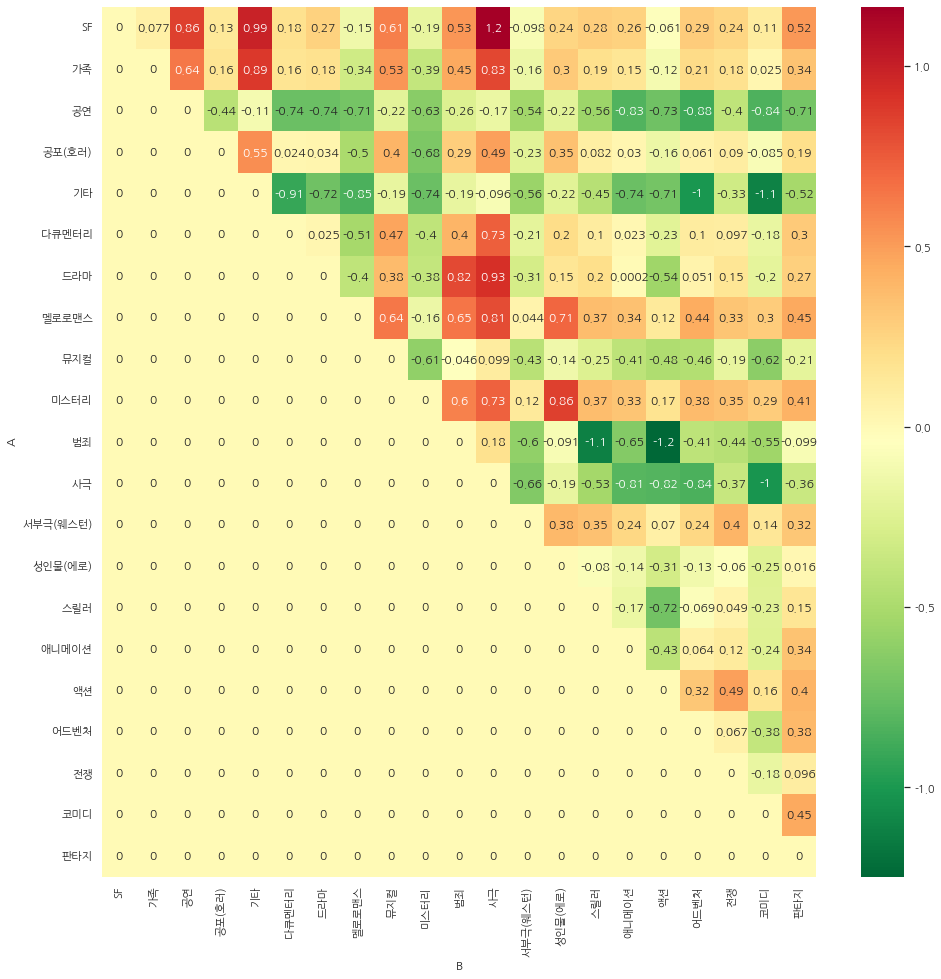

In [136]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

# attribute별 WEAT score 행렬을 히트맵으로 표현
_, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', ax=ax)
ax.set_ylabel('A')
ax.set_xlabel('B')
plt.show()

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        score = matrix[i][j]
        if score >= 0.8 or score <= -0.8:
            print(f'{genre_name[i]} vs {genre_name[j], WEAT score: {score}}')
            if score > 0:
                print(f'예술 영화-{genre_name[i]}  일반 영화-{genre_name[j]}')
            else:
                print(f'예술 영화-{genre_name[j]}  일반 영화-{genre_name[i]}')